# Problem Set 1 - K-Nearest Neighbor and NaiveBayes classifiers
## CSCI 4622 - Spring 2022

Student name < John Wilson >

Only submit this notebook to canvas (no zip files).

For today's assignment, we will be implementing our own K-Nearest Neighbors classifier (KNNClassifier) algorithm and a
 Naive Bayes classifier.

*But Professor Quigley, hasn't someone else already written KNN before?*

Yes, you are not the first to implement KNN, or basically any algorithm we'll work with in this class. But
1. I'll know that you know what's really going on
2. You'll know you can do it, because
    1. someday you might have to implement some machine learning algorithm from scratch - maybe for a new platform (do you need to run python on your SmartToaster just to get it to
learn how users like their toast?), maybe because you want to tweak the algorithm (there's always a better approach...),
    2. maybe because you're working on something important, and you need to control exactly what's on there
(should you really be running anaconda on your secret spy plane?).

That said - we're not going to implement *everything*. We'll start by importing a few helper functions

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors
import data
import tests
%matplotlib inline

*Wait a minute - didn't we just import Scikit-learn (sklearn)? The package with baked-in machine learning tools?*
 Yes - but it also has a ton of helper functions that we'll be using later.

You will be guided through the different questions and you'll be expected to complete the classes and the functions following the provided signatures.
 Sometimes at the end of a question we would provide a difficulty estimate using
the average scored by students who attempted the question (or a similar one) in previous assignments.

Remember to avoid adding positional arguments and make sure the returned values have the correct format (this applies to all assignments).
The alternative is that your solution might be rejected by the auto-grader (we won't be debugging your code).
We will provide some basic sanity checks. They're in no means exhaustive and passing them does not imply
your solution is 100% correct.


For example, you're required to complete the method `compute_something` of class A.
We provide examples of acceptable solutions.

In [58]:
# This cell can be removed from the submitted notebook
class A:
    def compute_something(self, X):
        """
        :return: numpy array of zeros, with shape (4,)
        """
        # BEGIN
        answer = np.zeros((4,))
        # END
        return answer


class A1:  # Acceptable solution:
    # - the added y is an optional argument and omitting it does not affect the solution
    # - the returned object has the expected structure.
    def compute_something(self, X, y=None):
        # BEGIN
        return np.zeros((4,))
        # END


class A2:  # Wrong format:
    # - your solution requires a new positional argument y!
    # - the returned object does not have the expected format!
    # - solution outside the delimiters # BEGIN # END
    def compute_something(self, X, y):
        return [0, 0, 0, 0]


class A3:  # Acceptable solution:
    # You're free to add your own helper functions/methods
    def compute_something(self, X):
        # BEGIN
        return self.get_zeros(4)
        # END

    def get_zeros(self, i):
        return np.zeros((i,))





First, let's also load a dataset to play with and start working to build out our own classifier.

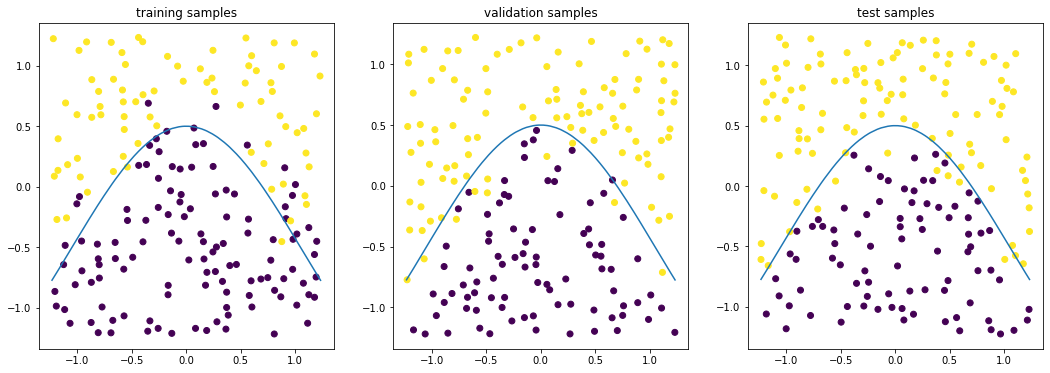

In [59]:
binary_data = data.BinaryData()
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
for i, name in enumerate(["training", "validation", "test"]):
    axs[i].plot(*binary_data.boundary())
    axs[i].set_title("%s samples" % name)
axs[0].scatter(binary_data.X_train[:, 0], binary_data.X_train[:, 1], c=binary_data.y_train)
axs[1].scatter(binary_data.X_valid[:, 0], binary_data.X_valid[:, 1], c=binary_data.y_valid)
axs[2].scatter(binary_data.X_test[:, 0], binary_data.X_test[:, 1], c=binary_data.y_test)
plt.show()

We have data! The `binary_data` instance has the following attributes:
   - a training set (`X_train, y_train`): to train the model and on which the prediction is based
   - a validation set (`X_valid, y_valid`): to select the best __hyper-parameters__ of the model
   - a test set (`X_test, y_test`): to evaluate the performance of the model on unseen data

### Problem 1: Complete our KNN Classifier - 40 Points

The KNNClassifier class we're implementing will have similar design to the K-Nearest Neighbors classifier class from *scikit-learn*:
- Initialize the classifier with corresponding parameters (number of neighbors k)
- A `fit` method that uses the training data
- A `predict` method that returns the predicted labels given data `X`

We've written out a lot of the structure for you for consistency across different parts of the assignment and so
you can focus on the "important" stuff that actually relates to the machine learning itself.

In [60]:
class KNNClassifier:

    def __init__(self, k=5):
        """
        Initialize our custom KNN classifier
        :param k: the number of nearest neighbors to consider for classification
        """
        self._k = k
        self._ball_tree = None
        self._y = None
        self.label_to_index = None
        self.index_to_label = None

    def fit(self, X, y):
        """
        Fit the model using the provided data
        :param X: 2-D np.array of shape (number training samples, number of features)
        :param y: 1-D np.array of shape (number training samples,)
        :return: self
        """
        self._ball_tree = sklearn.neighbors.BallTree(X)  # See documentation of BallTree and how it's used
        self._y = y
        # Should be used to map the classes to {0,1,..C-1} if needed (C is the number of classes)
        # We can assume that the training data contains samples from all the possible classes
        classes = np.unique(y)
        self.label_to_index = dict(zip(classes, range(classes.shape[0])))
        self.index_to_label = dict(zip(range(classes.shape[0]), classes))

        return self

    def majority_vote(self, indices_nearest_k, distances_nearest_k=None):
        """
        Given indices of the nearest k neighbors for each point, report the majority label of those points.
        :param indices_nearest_k: np.array containing the indices of training neighbors, of shape (M, k)
        :param distances_nearest_k: np.array containing the corresponding distances of training neighbors, of shape (M, k)
        :return: The majority label for each row of indices, shape (M,)
        """

        # Workspace 1.1
        # TODO: Determine majority for each row of indices_nearest_k
        # TODO: if there is a tie, remove the farthest neighbor until the tie is broken
        #BEGIN 
        voted_labels = np.empty(indices_nearest_k.shape[0])
        # code here
        vote_index = 0
        row_labels = np.empty(len(self.label_to_index), dtype=int)
        row_labels[:] = 0
        for i in indices_nearest_k:
            for j in i:
                row_labels[self.label_to_index[self._y[j]]]+=1
            max_value = np.max(row_labels)
            max_index = np.where(row_labels == max_value)
            while len(max_index[0]) > 1:
                row_labels[self.label_to_index[self._y[i[-1]]]]-=1
                max_index = np.where(row_labels == max_value)
            voted_labels[vote_index] = self.index_to_label[max_index[0][0]]
            vote_index += 1
            row_labels[:] = 0
        #END
        return voted_labels

    def predict(self, X):
        """
        Given new data points, classify them according to the training data provided in fit and number of neighbors k
        You should use BallTree to get the distances and indices of the nearest k neighbors
        :param X: feature vectors (num_points, num_features)
        :return: 1-D np.array of predicted classes of shape (num_points,)
        """
        # Workspace 1.2
        #BEGIN 
        # code here
        distances_nearest_k, indices_nearest_k = self._ball_tree.query(X, self._k)  # REPLACE
        #END
        return self.majority_vote(indices_nearest_k, distances_nearest_k)

    def confusion_matrix(self, X, y):
        """
        Generate the confusion matrix for the given data
        :param X: an np.array of feature vectors of points, shape (N, n_features)
        :param y: the corresponding correct classes of our set, shape (N,)
        :return: a C*C np.array of counts, where C is the number of classes in our training data
        """
        # The rows of the confusion matrix correspond to the counts from the true labels, the columns to the predictions'
        # Workspace 1.3
        # TODO: Run classification for the test set X, compare to test answers y, and add counts to matrix
        c_matrix = np.zeros((len(self.label_to_index), len(self.label_to_index)))
        #BEGIN 
        # code here
        test_labels = self.predict(X)
        true_label_index = 0
        for i in test_labels:
            if int(i) == y[true_label_index]:
                c_matrix[self.label_to_index[int(i)]][self.label_to_index[int(i)]]+=1
            else:
                c_matrix[self.label_to_index[y[true_label_index]]][self.label_to_index[int(i)]]+=1
            true_label_index+=1       
        #END
        return c_matrix

    def accuracy(self, X, y):
        """
        Return the accuracy of the classifier on the data (X_test, y_test)
        :param X: np.array of shape (m, number_features)
        :param y: np.array of shape (m,)
        :return: accuracy score [float in (0,1)]
        """
        # Workspace 1.4
        # TODO: Compute accuracy on X
        #BEGIN 
        # code here
        c_matrix = self.confusion_matrix(X,y)
        sum_correct = 0
        sum_total = 0
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[1]):
                sum_total += c_matrix[i][j]
                if i == j:
                    sum_correct += c_matrix[i][j]
        score = sum_correct/sum_total # REPLACE
        #END
        return score

In [61]:
# Test cell, uncomment to run the tests
tests.testKNN(KNNClassifier)

Question 1.1: [PASS]
Question 1.2: [PASS]
Question 1.3: [PASS]
Question 1.4: [PASS]


*But professor, this code isn't complete!*

1.1 [10 points] Complete the `majority_vote` function to determine the majority class of a series of neighbors.
If there is a tie, then you should remove the farthest element until the tie is broken. (Avg __9.6__)

1.2 [5 points] Complete the `predict` function to capture the predicted class of a new datapoint (Avg __4.9__)

 - HINT: Use the BallTree documentation to determine how to retrieve neighbors from the model (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.BallTree.html#sklearn.neighbors.BallTree)

1.3 [5 points] Complete the `confusion_matrix` function to reveal the results of classification (Avg __5__)

1.4 [5 points] Complete the `accuracy` function to get accuracy of the classifier based on a given test data (Avg __5__)

Below, we'll be using our KNNClassifier (sent in as "model") to show how we would predict any points in space given the input data.

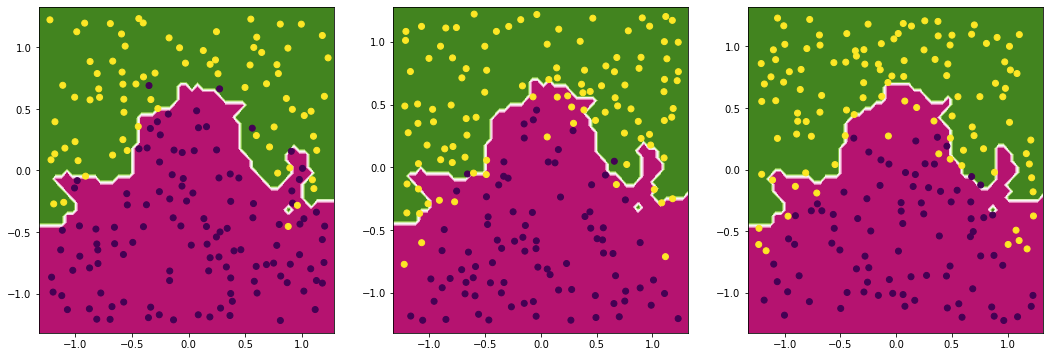

In [62]:
# This cell is to show the decision surface of the classifier
# You can change k to visualize KNN behavior
knn = KNNClassifier(4).fit(binary_data.X_train, binary_data.y_train)
fig, axs = plt.subplots(1, 3)
fig.set_figheight(6), fig.set_figwidth(18)
tests.show_decision_surface(knn, binary_data.X_train, binary_data.y_train, axs[0])
tests.show_decision_surface(knn, binary_data.X_valid, binary_data.y_valid, axs[1])
tests.show_decision_surface(knn, binary_data.X_test, binary_data.y_test, axs[2])
plt.show()

1.5 [10 points] For each k in the range [1,32], fit a KNNClassifier on the training set and plot the accuracies on training and validation
data versus k. What's the value of k that yields the best accuracy on the training set? on the validation set? Which one
 should we choose? (Avg __9.8__)

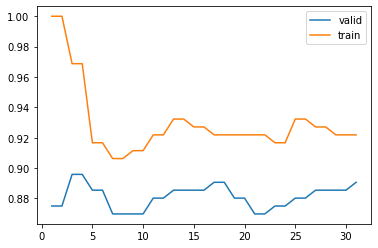

In [63]:
# Workspace 1.5.a
#TODO: Try different Ks
ks = list(range(1, 32))
accuracies_train = []
accuracies_valid = []
for k in ks:
    #BEGIN 
    # code here
    knn = KNNClassifier(k).fit(binary_data.X_train, binary_data.y_train)
    accuracies_valid.append(knn.accuracy(binary_data.X_valid, binary_data.y_valid))
    accuracies_train.append(knn.accuracy(binary_data.X_train, binary_data.y_train))
    #END
plt.plot(ks, accuracies_valid, label="valid")
plt.plot(ks, accuracies_train, label="train")
plt.legend()
plt.show()

### # Workspace 1.5.b
% Write up: best k for training and validation and which one should we choose

% best k for training: 1-2 = 100%
% best k for validation: 3-4 = ~89%
% one we should choose: k=4

1.6 [5 points] Report the accuracy and the confusion matrix on the test set using the value of k chosen in 1.5 (Avg __5__)

In [64]:
# Workspace 1.6
# TODO: compute and print the accuracy on the test set using k from 1.5
#BEGIN 
# code here
best_k = 4 # REPLACE
knn = KNNClassifier(best_k).fit(binary_data.X_train, binary_data.y_train)
print(knn.confusion_matrix(binary_data.X_test, binary_data.y_test))
print(knn.accuracy(binary_data.X_test, binary_data.y_test))
#END

[[81.  2.]
 [19. 90.]]
0.890625


**Bonus (for the avid machine learner) (4 Points)**

1.7.a [2 point] A [__consistent classifier__](https://proceedings.neurips.cc/paper/1996/file/7bb060764a818184ebb1cc0d43d382aa-Paper.pdf)
on the training data is defined as a classifier that reaches 100% accuracy on the training set. For which values of k is KNNClassifier Consistent? (Avg __1__)

1.7.b [2 points] Edit your `KNNClassifier` so that it's consistent for all $k$ (we made sure that the change does not affect the sanity checks) (Avg __1__)

#### Write-up for the bonus
**Workspace 1.7.a**

% for which k in KNNClassifier consistent

% k = 2

***
OK - now we've demonstrated that our KNN classifier works, let's think about our problem space! 

## Our Dataset - Identifying Digits from Images

It's a pretty common problem - just imagine working at the post office, and you're handed a hand-written check,
and you have to identify exactly what it says.
Did they pay 500 or 600 dollars? Is the letter going to 80309 (campus) or 30309 (Atlanta)?


### Problem 2: Improving KNN on Digits dataset - 25 Points

2.1 [7 points] `report` the number of examples different partitions of the digit dataset adn the number of pixels in the images (Avg __6.8__)

2.2 [8 points] complete the `evaluate` to perform the same evaluation we did in 1.5:
 - For k in range (1, 20):
    - initialize the classifier for k  and train in on the training set
    - Compute the accuracy on the validation set and save it
 - Choose k with the best accuracy on the validation set
 - Report the accuracy and the confusion matrix on the test set (use `display_confusion` for a cleaner output)



In [65]:
class Numbers:
    def __init__(self):
        self.data = data.DigitData() # it has the same structure as binary_data

    def report(self):
        """
        Report information about the dataset using the print() function
        """
        # Workspace 2.1
        #TODO: Create print-outs for reporting the size of each set and the size of each datapoint
        #BEGIN 
        # code here
        print("Training set length:", len(self.data.X_train))
        print("Training set data size", self.data.X_train[0].shape)
        print("Validation set length:", len(self.data.X_valid))
        print("Validation set data size", self.data.X_valid[0].shape)
        print("Test set length:", len(self.data.X_test))
        print("Test set data size", self.data.X_test[0].shape)
        #END

    def evaluate(self, classifier_class):
        """
        valuates instances of the classifier class for different values of k and performs model selection
        :param classifier_class: Classifier class (either KNNClassifier or WeightedKNNClassifier)
        """
        # Workspace 2.2

        ks = list(range(1, 20))
        accuracies_valid = []
        #BEGIN 
        # code here (anything between BEGIN and END is yours to edit if needed)
        best_valid_k = None
        confusion_matrix = None
        accuracy = 0
        for k in ks:
            classifier_class_k = k 
            classifier_class.fit(self.data.X_train, self.data.y_train)
            accuracies_valid.append(classifier_class.accuracy(self.data.X_valid, self.data.y_valid))
            if accuracy < classifier_class.accuracy(self.data.X_valid, self.data.y_valid):
                accuracy = classifier_class.accuracy(self.data.X_valid, self.data.y_valid)
                best_valid_k = k
        confusion_matrix = classifier_class.confusion_matrix(classifier_class, self.data.X_valid, self.data.y_valid)
        #END
        print("best k:", best_valid_k)
        print("Accuracy on test set:", accuracy)
        self.display_confusion(confusion_matrix)

    def view_digit(self, index, partition):
        """
        Display a digit given its index and partition
        :param index: index of the digit image
        :param partition: partition from which the digit is retrieved, either "train", "valid" or "test"
        """
        image = {"train": self.data.X_train, "valid": self.data.X_valid, "test": self.data.X_test}[partition][index]
        label = {"train": self.data.y_train, "valid": self.data.y_valid, "test": self.data.y_test}[partition][index]
        image = image.reshape(28, 28)
        plt.figure()
        plt.matshow(image)
        plt.title("Digit %i" % label)
        plt.show()

    @staticmethod
    def display_confusion(c_matrix):
        """
        Displays the confusion matrix using matshow
        :param c_matrix: square confusion matrix, shape (num_classes, num_classes)
        """
        _, ax = plt.subplots()
        ax.matshow(c_matrix, cmap=plt.cm.Blues)
        for i in range(c_matrix.shape[0]):
            for j in range(c_matrix.shape[0]):
                ax.text(i, j, str(c_matrix[j, i]), va='center', ha='center')
        plt.show()



In [66]:
numbers = Numbers()
numbers.report()
numbers.evaluate(KNNClassifier)

Training set length: 1000
Training set data size (784,)
Validation set length: 500
Validation set data size (784,)
Test set length: 500
Test set data size (784,)


TypeError: fit() missing 1 required positional argument: 'y'

In [ ]:
print("I never got to to the rest, I tried my best but comedy is more fun")



2.3 [10 points] Determine which classes are most often confused (from our confusion matrix above),
 inspect some examples of these digits (using the `view_digit` function in our Numbers class),
 and write a brief (4 - 5 sentences) description of why you think these particular numbers may be misclassified. (Avg __9.1__)

In [ ]:
# Workspace 2.3.a
#TODO: Print out problem class images
#BEGIN 
# code here
#END

**Workspace 2.3.b**

TODO: Write description of mis-classification

% YOUR ANSWER HERE

### Problem 3 - Naive Bayes [35 points]
***
Consider the problem of predicting whether a person has a college degree based on age, salary, and Colorado residency.
The dataset looks like the following.

|Age|Salary|Colorado Resident| Has Siblings | College degree|
|:------:|:-----------:| :----------:| :----------:|--:|
| 37 | 44,000 | Yes | No  | Yes|
| 61 | 52,000 | Yes | No  | No |
| 23 | 44,000 | No  | No  | Yes|
| 39 | 38,000 | No  | Yes | Yes|
| 48 | 49,000 | No  | No  | Yes|
| 57 | 92,000 | No  | Yes | No |
| 38 | 41,000 | No  | Yes | Yes|
| 27 | 35,000 | Yes | No  | No |
| 23 | 26,000 | Yes | No  | No |
| 38 | 45,000 | No  | No  | No |
| 32 | 50,000 | No  | No  | No |
| 25 | 52,000 | Yes | No  | No |


In [ ]:
features = np.array([
    [37, 44000, 1, 0],
    [61, 52000, 1, 0],
    [23, 44000, 0, 0],
    [39, 38000, 0, 1],
    [48, 49000, 0, 0],
    [57, 92000, 0, 1],
    [38, 41000, 0, 1],
    [27, 35000, 1, 0],
    [23, 26000, 1, 0],
    [38, 45000, 0, 0],
    [32, 50000, 0, 0],
    [25, 52000, 1, 0]
])
labels = np.array([1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1])

3.1 [5 points] Complete `threshold_features` to convert age and salary features to binary ones using the threshold arguments. (Avg __4.9__)

In [ ]:
def threshold_features(features, age_threshold, salary_threshold):
    """
    Transform age and salary to binary
    :param features: data array of shape (m, n_features) where features[:,0] for age, features[:,1} for salary
    :param age_threshold: used to "binarize" the data, 1 if age > age_threshold and 0 otherwise
    :param salary_threshold: used to "binarize" the data, 1 if salary > salary_threshold and 0 otherwise
    :return: binary features matrix
    """
    binary_features = features * 1  #This row just creates a "hard copy" of the X array so we can manipulate it as needed

    # Workspace 3.1
    #BEGIN 
    # code here
    #END

    return binary_features

In [ ]:
# Test cell, uncomment to run the tests
# tests.test_threshold(threshold_features)

3.2 [3 points] If we were to use only one binary feature (age >40, salary > 40000, colorado resident, has siblings),
then what's the highest accuracy we could achieve? Which feature should we use?

**Workspace 3.2**

% YOUR ANSWER HERE

## How to implement NaiveBayes
As seen during the class, given a row $(x_1, x_2, x_3)$, the naive Bayes classifier should assign the label $y$ that
maximizes:

\begin{align}
\log [p(y) \prod_i p(x_i | y)] = \log p(y) + \sum_{i} \log p(x_i | y)
\end{align}

$p(y)$ and $p(x_i | y)$ are computed using the training set (during `fit` call).

For this, we need two attributes to store
$\log p(y)$ and $\log p(x_i | y)$ for different features $i$.

Let's assume we're working with binary classes $\{0, 1\}$ and all features have discrete supports.
Then we will store `classes_log_probability` as an array of shape `(2,)` that contains:
\begin{bmatrix}
\log p(y=0),\log p(y=1)
\end{bmatrix}.

If feature $i$ has $2$ possible values $\{0, 1\}$, then $\log p(x_i | y)$ would be stored as a $ 2 \times 2$ matrix:
\begin{align}
A_i = \begin{bmatrix}
\log p(x_i=0 | y=0) & \log p(x_i=1| y=0)\\
\log p(x_i=0 | y=1) & \log p(x_i=1 | y=1)
\end{bmatrix}
\end{align}

`features_log_likelihood` should then store such matrix for each feature.

We have defined $p(x_i | y)$ as :
\begin{align}
p(x_i | y) = \frac{N_{y,x_i}}{N_y}
\end{align}
where $N_{y,i}$ is the number of rows where $y$ and $x_i$ occur together, and $N_y = \sum_i N_{y,x_i}$.

3.3 [5 points] Complete the method `compute_classes` and store the log prior in `classes_log_probability` (Avg __5__)

3.4 [7 points] Complete the method `compute_features` by storing the matrices $A_i$ in `self.features_log_likelihood` (Avg __6.3__)

3.5 [5 points] Complete the method `join_log_likelihood` that computes the likelihood quantities
 $[\sum_{i} \log p(x_i | y=0), \sum_{i} \log p(x_i | y=1)]$ for each observation

3.6 [5 points] Complete the `predict` method

In [ ]:
class NaiveBayes(object):
    """
    NaiveBayes classifier for binary features and binary labels
    """

    def __init__(self, alpha=0.0):
        self.alpha = alpha
        self.classes_counts = None
        self.classes_log_probability = np.empty((2,))
        self.features_log_likelihood = []  # list of arrays where element i store log p(X[:,i], y)

    def compute_classes(self, y):
        """
        Computes the log prior of binary classes and stores the result in self.classes_log_probability
        :param y: binary labels array, shape (m,)
        """
        # Workspace 3.3
        #BEGIN 
        # code here
        #END

    def compute_features(self, X, y):
        """
        Computes the log likelihood matrices for different features and stores them in self.features_log_likelihood
        :param X: data matrix with binary features, shape (n_samples, n_features)
        :param y: binary labels array, shape (n_samples,)
        """
        # Workspace 3.4
        #BEGIN 
        # code here
        #END

    def fit(self, X, y):
        """
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :param y: corresponding binary labels of shape (n_samples,) [values 0 or 1]
        :return: Classifier
        """
        self.compute_classes(y)
        self.compute_features(X, y)
        return self

    def joint_log_likelihood(self, X):
        """
        Computes the joint log likelihood
        :param X: binary np.array of shape (n_samples, n_features) [values 0 or 1]
        :return: joint log likelihood array jll of shape (n_samples, 2), where jll[i] = [log p(X[i]|y=0),log p(X[i]|y=1)]
        """
        # Workspace 3.5
        #BEGIN 
        joint_log_likelihood = np.zeros((X.shape[0], 2))
        # code here
        #END
        return joint_log_likelihood

    def predict(self, X):
        """
        :param X:
        :return:
        """

        # Workspace 3.6
        # TODO: Find the corresponding labels using Naive bayes logic
        #BEGIN 
        # code here
        y_hat = np.zeros((X.shape[0],))
        #END
        return y_hat

In [ ]:
# Test cell, uncomment to run the tests
# tests.test_NB(NaiveBayes)

3.7 [5 points] Using age 40 and salary 40,000 as thresholds, transform the features and evaluate (accuracy) the NaiveBayes classifier
on the training data. Does it outperform our baseline (of using one feature)? (Avg __4.5__)

In [ ]:
naive_bayes = NaiveBayes()
# Workspace 3.7
#TODO: Transform features to binary features, fit the classifier, report the accuracy
#BEGIN 
# code here
#END

**Bonus**

3.8 [2 points] Use the attribute `alpha` of the NaiveBayes to convert it to smoothed NaiveBayes presented during the class.
`alpha`defaults to 0, so editing the class should not affect NaiveBayes tests (Avg __1.8__)